# Домашнее задание 3 [10 баллов] 
# До 30.04.18 23:59

Задание выполняется в группе (1-4 человека). В случае использования какого-либо строннего источника информации обязательно дайте на него ссылку (поскольку другие тоже могут на него наткнуться). Плагиат наказывается нулём баллов за задание и предвзятым отношением в будущем.

Не все части обязательны для выполнения, однако вы можете быть дополнительно оштрафованы за небрежное за выполнение одной или двух частей вместо четырех.

При возниконовении проблем с выполнением задания обращайтесь с вопросами к преподавателю. Поэтому настоятельно рекомендуется выполнять задание заранее, оставив запас времени на всевозможные технические проблемы. Если вы начали читать условие в последний вечер и не успели из-за проблем с установкой какой-либо библиотеки — это ваши проблемы.


Результат выполнения задания — это отчёт в формате html на основе Jupyter Notebook. Нормальный отчёт должен включать в себя:
* Краткую постановку задачи и формулировку задания
* Описание **минимума** необходимой теории и/или описание используемых инструментов - не стоит переписывать лекции или Википедию
* Подробный пошаговый рассказ о проделанной работе
* Аккуратно оформленные результаты
* **Внятные выводы** – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

Небрежное его оформление отчета существенно отразится на итоговой оценке. Весь код из отчёта должен быть воспроизводимым, если для этого нужны какие-то дополнительные действия, установленные модули и т.п. — всё это должно быть прописано в тексте в явном виде.

Сдача отчетов осуществляется через систему AnyTask.


## Использование архитектуры SENNA для определения части речи

Домашнее задание написано по мотивам работы R. Collobert:

**Collobert, Ronan, Jason Weston, Léon Bottou, Michael Karlen, Koray Kavukcuoglu, and Pavel Kuksa. "Natural language processing (almost) from scratch." Journal of Machine Learning Research 12, no. Aug (2011): 2493-2537.**

В этом домашнем задании вам предстоит самостоятельно разработать архитектуру SENNA для определения части речи. 
SENNA – это простая архитектура нейронной сети, позволяющая достигнуть state-of-the-art результатов в нескольких задачах обработки текстов.  

Использование SENNA для определения части речи предполагает, что задача определения части речи для данного слова формулируется как задача классификации: пусть в размеченном корпусе всего $|T|$ (= tagset) различных тегов частей речи, тогда каждое слово $w$ относится к одному из $T$ классов. Для каждого слова из обучающих данных формируется собственный вектор признаков. Нейронная сеть обучается по всем векторам признаков для слов из обучающего множества. 

Подход к решению задачи классификации представлен в оригинальной статье на рис. 1 (Figure 1: Window approach network). Он состоит из следующих шагов (раздел 3.3.1):
1. Каждое слово представляется эмбеддингом: $w_i \rightarrow LT_{w^i}$, размерность эмбеддинга - $d$;
2. Для каждого слова формируется окно длины $k$ из $(k-1)/2$ соседних слов слева от данного слова  и $(k-1)/2$ соседних слов справа от данного слова, $k$ – нечетное. 
3. Для каждого слова формируется вектор признаков, состоящий из конкатенированных эмбеддингов слов из левого окна, данного слова и слов из правого окна. Итоговая размерность вектора признаков – $d \times k$. Именно этот вектор подается на вход нейронной сети;
4. Обучается нейронная сеть, имеющая один скрытый слой с $n_h$ нейроннами и нелинейной функцией активации $\theta$;
5. На выходном слое нейронной сети решается задача классификации на |T| классов, то есть, определяется часть речи для каждого слова. 

Если для слова невозможно найти $(k-1)/2$ соседних слов слева от данного слова  и $(k-1)/2$ соседних слов справа от данного слова – используется padding.


### Данные
1. Открытый корпус: https://github.com/dialogue-evaluation/morphoRuEval-2017/blob/master/OpenCorpora_Texts.rar
2. Предобученные эмбеддинги Facebook: https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.ru.vec

### Часть 1 [2 балла] Подготовка данных
1. Прочитайте размеченные данные Открытого корпуса, используя nltk.corpus.reader.conll.ConllCorpusReader
2. Посчитайте количество предложений и число тегов частей речи;
3. Сформируйте тестовое и обучающее множество: первые 3/4 данных – обучающее множество;

Для каждого слова:
1. Определите его окно (слова слева и справа) размера $k$;
2. Сформируйте его вектор признаков.

In [93]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus.reader.conll import ConllCorpusReader
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from IPython import display
from tqdm import tqdm

%matplotlib inline

Читаем данные

In [2]:
root = './data/'
fileids = ['unamb_sent_14_6.conllu']
columntypes = ['ignore', 'words', 'ignore', 'pos', 'chunk']
pos_corpus = ConllCorpusReader(root, fileids, columntypes)

Считаем количество предложений и тегов частей речи

In [3]:
corpus = list(pos_corpus.iob_sents())

In [4]:
pos_tags = [pos for text in corpus for word, pos, chunk in text]

In [5]:
sentenses = [[word for word, pos, chunk in text] for text in corpus]

In [6]:
print(len(sentenses), len(pos_tags))

38508 457583


Формируем тестовое и обучающее множество

In [7]:
train_sent, test_sent = sentenses[:int(len(sentenses) * 0.75)], sentenses[int(len(sentenses) * 0.75):]
train_pos_tags, test_pos_tags = pos_tags[:int(len(pos_tags) * 0.75)], pos_tags[int(len(pos_tags) * 0.75):]

In [8]:
print(len(sentenses), len(train_sent), len(test_sent))
print(len(pos_tags), len(train_pos_tags), len(test_pos_tags))

38508 28881 9627
457583 343187 114396


Создадим словарь используемых слов в предложениях

In [9]:
vocab = {word.lower() for sent in sentenses for word in sent}

In [10]:
len(vocab)

79791

Переведем метки частей речи в индексы

In [11]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(pos_tags)

In [12]:
y = integer_encoded

onehot_encoder = OneHotEncoder(sparse=True)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

Закодируем все слова в индексы

In [13]:
# Полагаю не надо объяснять как я установил keras и tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/Users/maxim/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/maxim/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [14]:
# prepare tokenizer
t = Tokenizer(filters='')
t.fit_on_texts([' '.join(sent) for sent in sentenses])
vocab_size = len(t.word_index) + 1

In [15]:
vocab_size

79792

In [16]:
# integer encode the documents
encoded_sentences = t.texts_to_sequences([' '.join(sent) for sent in sentenses])

In [17]:
[' '.join(sent) for sent in sentenses[:3]]

['« Школа злословия » учит прикусить язык',
 'Сохранится ли градус дискуссии в новом сезоне ?',
 'Великолепная « Школа злословия » вернулась в эфир после летних каникул в новом формате .']

In [18]:
encoded_sentences[:3]

[[7, 972, 7657, 8, 11067, 31989, 1116],
 [19860, 31990, 14203, 5074, 3, 1117, 1879, 26],
 [14204, 7, 972, 7657, 8, 3758, 3, 2425, 56, 9042, 31991, 3, 1117, 2426, 1]]

Построим для каждого слова его контекст(окно размером k)

In [19]:
def get_window(i, sent, k):
    window = []
    j = int(i - (k-1)/2)
    while j <= i + (k-1)/2:
        if j < 0 or j >= len(sent):
            window.append(0)
        else:
            window.append(sent[j])
        j += 1
    return window

In [20]:
%%time
k = 5
X = np.asarray([get_window(i, sent, k) 
                for sent in encoded_sentences for i, word in enumerate(sent)], dtype=np.int32)

CPU times: user 1.81 s, sys: 46.6 ms, total: 1.85 s
Wall time: 1.87 s


Проверим, что X и y созданы верно

In [21]:
X[:8]

array([[    0,     0,     7,   972,  7657],
       [    0,     7,   972,  7657,     8],
       [    7,   972,  7657,     8, 11067],
       [  972,  7657,     8, 11067, 31989],
       [ 7657,     8, 11067, 31989,  1116],
       [    8, 11067, 31989,  1116,     0],
       [11067, 31989,  1116,     0,     0],
       [    0,     0, 19860, 31990, 14203]], dtype=int32)

In [23]:
print(X.shape, y.shape)

(457583, 5) (457583,)


Разобьем X и y на train и test(а не то что попросили в задании), но, в угоду составителю, не при помощи train_test_split

In [24]:
X_train, X_test = X[:int(X.shape[0] * 0.75)], X[int(X.shape[0] * 0.75):]
y_train, y_test = y[:int(y.shape[0] * 0.75)], y[int(y.shape[0] * 0.75):]

In [25]:
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(457583, 5) (343187, 5) (114396, 5)
(457583,) (343187,) (114396,)


Загрузим embedding в память

In [26]:
%%time
file_name = 'data/wiki.ru.vec'
embeddings_index = dict()
with open(file_name) as f:
    line = f.readline()
    n_words, embedding_size = map(int, line.split())
    for line in f:
        values = line.strip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1862490 word vectors.
CPU times: user 2min 25s, sys: 8.05 s, total: 2min 33s
Wall time: 2min 41s


Создадим матирцу embedding

In [27]:
%%time
embedding_matrix = np.zeros((vocab_size, embedding_size))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

CPU times: user 489 ms, sys: 664 ms, total: 1.15 s
Wall time: 1.5 s


In [28]:
del embeddings_index

### Часть 2 [4 баллов] Архитектура нейронной сети

Архитектура нейронной сети состоит из следующих слов:
1. Входной слой: нейронная сеть получает на вход вектор признаков, состоящий из $k$ конкатенированных эмбеддингов;/
2. Скрытый слой: $n_h$ нейронов и нелинейная функция активации $\theta$;
3. Выходной слой:  $|T|$ нейронов для итоговой классификации.

Обучите нейронную сеть на обучающих данных.

In [125]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, LSTM, Dense, LeakyReLU, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from keras import regularizers

Построим модель

In [132]:
def build_model(vocab_size, embedding_size, embedding_matrix, k, n_units, output_size, lr=0.001, 
                dense_activation='relu', dropout_rate=0.2, l2=0., **kwargs):
    model = Sequential()
    model.add(
        Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=k, trainable=False)
    )
#     model.add(Flatten())
    model.add(Dense(n_units, activation=dense_activation, kernel_regularizer=regularizers.l2(l2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(output_size, activation='softmax'))
    # compile the model
    optimizer = Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

Обучим

In [86]:
def train_model(model, X, y, n_epoches, n_initial_epoch=0, batch_size=128, callbacks=[], **kwargs):
    return model.fit(X, y, batch_size=batch_size, epochs=n_epoches, initial_epoch=n_initial_epoch, 
                     validation_split=0.1, callbacks=callbacks)

Изобразим процесс обучения на графике

In [51]:
def history_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

Сохраним

In [52]:
def get_last_n(path_to_folder):
    try:
        last_model_n = max(list(map(lambda name: int(name.replace('.h5', '').replace('.json', '').split('_')[-1]), 
                                     filter(lambda name: (name.startswith('model_weights_') or 
                                            name.startswith('model_weights_')), 
                                            os.listdir(path_to_folder)))))
    except:
        last_model_n = 0
    return last_model_n

def save_model(model, path_to_folder):
    last_n = get_last_n(path_to_folder)
    new_n = last_n + 1
    model.save_weights(os.path.join(path_to_folder, 'model_weights_' + str(new_n) + '.h5'))
    with open(os.path.join(path_to_folder, 'model_architecture_' + str(new_n) + '.json'), 'w') as f:
        f.write(model.to_json())
    print('Created:')
    print(os.path.join(path_to_folder, 'model_weights_' + str(new_n) + '.h5'))
    print(os.path.join(path_to_folder, 'model_architecture_' + str(new_n) + '.json'))

Посчитаем значение метрик на тесте

In [77]:
def eval_test_score(model, X_test, y_test):
    loss, acc = model.evaluate(X_test, y_test)
    print("Loss: {:.3f}, acc: {:.2f}%".format(loss, acc*100))
    return loss, acc

Теперь это все запустим

In [127]:
n_units = 128
lr = 0.001
output_size = len(label_encoder.classes_)
model = build_model(vocab_size, embedding_size, embedding_matrix, k, n_units, output_size, lr, 
                    dropout_rate=0.4, l2=0.001)

In [128]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 5, 300)            23937600  
_________________________________________________________________
dense_39 (Dense)             (None, 5, 128)            38528     
_________________________________________________________________
batch_normalization_17 (Batc (None, 5, 128)            512       
_________________________________________________________________
flatten_20 (Flatten)         (None, 640)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 640)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 14)                8974      
Total params: 23,985,614
Trainable params: 47,758
Non-trainable params: 23,937,856
___________________________________________________________

In [129]:
%%time
n_epoches = 10
batch_size = 128
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.005, patience=1, verbose=0, mode='auto'),
#     TensorBoard(log_dir='./data/logs', histogram_freq=3, batch_size=batch_size, write_graph=True, write_grads=True)
]

history = train_model(model, X_train, y_train, n_epoches, n_initial_epoch=0, 
                      batch_size=batch_size, callbacks=callbacks)

Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 42s 135us/step - loss: 0.4871 - acc: 0.8876 - val_loss: 0.3342 - val_acc: 0.9190
Epoch 2/10
308868/308868 [==============================] - 32s 103us/step - loss: 0.2754 - acc: 0.9347 - val_loss: 0.3018 - val_acc: 0.9248
Epoch 3/10
308868/308868 [==============================] - 32s 105us/step - loss: 0.2600 - acc: 0.9381 - val_loss: 0.3041 - val_acc: 0.9256
CPU times: user 3min 26s, sys: 10.9 s, total: 3min 37s
Wall time: 1min 46s


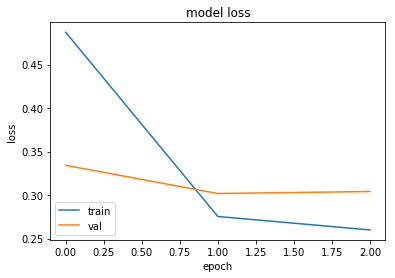

In [130]:
history_plot(history)

In [59]:
%%time
n_epoches = 10
batch_size = 128
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.005, patience=1, verbose=0, mode='auto'),
#     TensorBoard(log_dir='./data/logs', histogram_freq=3, batch_size=batch_size, write_graph=True, write_grads=True)
]

history = train_model(model, X_train, y_train, n_epoches, n_initial_epoch=0, 
                      batch_size=batch_size, callbacks=callbacks)

Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 28s 91us/step - loss: 0.3110 - acc: 0.9057 - val_loss: 0.2510 - val_acc: 0.9230
Epoch 2/10
308868/308868 [==============================] - 27s 88us/step - loss: 0.1622 - acc: 0.9495 - val_loss: 0.2332 - val_acc: 0.9289
Epoch 3/10
308868/308868 [==============================] - 27s 88us/step - loss: 0.1425 - acc: 0.9549 - val_loss: 0.2278 - val_acc: 0.9299
Epoch 4/10
308868/308868 [==============================] - 27s 88us/step - loss: 0.1303 - acc: 0.9582 - val_loss: 0.2238 - val_acc: 0.9349
CPU times: user 4min 29s, sys: 14.1 s, total: 4min 43s
Wall time: 1min 50s


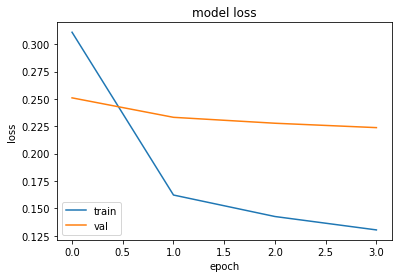

In [60]:
history_plot(history)

In [61]:
path_to_folder = 'data/models/'
save_model(model, path_to_folder)

Created:
data/models/model_weights_1.h5
data/models/model_architecture_1.json


### Часть 3 [1 балл] Оценка качества

Протестируйте нейронную сеть на тестовых данных. Используйте accuracy для оценки качества модели.

In [131]:
eval_test_score(model, X_test, y_test)

114396/114396 [==============================] - 9s 78us/step
Loss: 0.243, acc: 94.38%


(0.24323817995354122, 0.9438354487981683)

In [78]:
eval_test_score(model, X_test, y_test)

114396/114396 [==============================] - 8s 66us/step
Loss: 0.166, acc: 95.00%


(0.16644488316607142, 0.9499895101185633)

### Часть 4 [1 балл] Оптимизация гиперпарметров

В эксперименте участвуют следующие гиперпараметры:
* $k$ – размер окна;
* $n_h$ – число нейронов на скрытом слое;
* $\theta$ – вид функции активации.

Оцените их влияние на качество модели. Как увеличение окна или числа нейронов влияет на итоговый показатель качества? Зависит ли итоговый показатель качества от функции активации на скрытом слое? 

Функция, которая считает итоговые результаты при варьировании исследуемого параметра

In [116]:
def test_param(param_name, param_values, **kwargs):
    param_res = {}
    # если не k, то подгодовим X один раз в начале
    if param_name is not 'k':
        X = np.asarray([get_window(i, sent, kwargs['k']) 
                            for sent in encoded_sentences for i, word in enumerate(sent)], dtype=np.int32)
        X_train, X_test = X[:int(X.shape[0] * 0.75)], X[int(X.shape[0] * 0.75):]
    for param in tqdm(param_values):
        print('Param_name: {}, current value: {}'.format(param_name, param))
        # подготовка данных
        cur_kwargs = kwargs.copy()
        if param_name is 'k':
            k = param
            cur_kwargs['k'] = k
            X = np.asarray([get_window(i, sent, k) 
                            for sent in encoded_sentences for i, word in enumerate(sent)], dtype=np.int32)
            X_train, X_test = X[:int(X.shape[0] * 0.75)], X[int(X.shape[0] * 0.75):]
        if param_name is 'n_units':
            n_units = param
            cur_kwargs['n_units'] = n_units
        if param_name is 'dense_activation':
            dense_activation = param
            cur_kwargs['dense_activation'] = dense_activation
        # создание модели и ее обучение
        model = build_model(**cur_kwargs)
        history = train_model(model, X_train, y_train, **cur_kwargs)
        # получение результатов
#         display.clear_output(wait=True)
        history_plot(history)
        loss, acc = eval_test_score(model, X_test, y_test)
        param_res[param] = loss, acc, history
    return param_res

Строит итоговые графики ошибки и точности в зависимости от значения изменяемого параметра

In [109]:
def plot_res(param_name, param_res):
    x, loss, acc = list(map(list, zip(*[(param, v[0], v[1]) for param, v in param_res.items()])))
    plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, loss)
    plt.xlabel(param_name + " values")
    plt.ylabel('loss')
    plt.grid(True)
    plt.title(param_name + ' (loss)')
    
    plt.subplot(1, 2, 2)
    plt.plot(x, acc)
    plt.xlabel(param_name + " values")
    plt.ylabel('acc')
    plt.grid(True)
    plt.title(param_name + ' (acc)')

Начальное значение всех параметров

In [95]:
k = 5
n_units = 128
dense_activation = 'relu'

output_size = len(label_encoder.classes_)
lr = 0.001
n_epoches = 10
n_initial_epoch = 0
batch_size = 128
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.005, patience=1, verbose=0, mode='auto')
]

kwargs = {
    'k': k, 
    'n_units': n_units, 
    'dense_activation': dense_activation,
    
    'vocab_size': vocab_size, 
    'embedding_size': embedding_size, 
    'embedding_matrix': embedding_matrix, 
    'output_size': output_size, 
    'lr': lr,
    'n_epoches': n_epoches,
    'n_initial_epoch': n_initial_epoch, 
    'batch_size': batch_size,
    'callbacks': callbacks,
}

## Исследуем зависимость от размера окна k

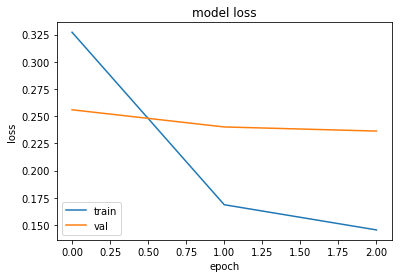

114396/114396 [==============================] - 12s 103us/step


100%|██████████| 6/6 [13:19<00:00, 133.27s/it]

Loss: 0.178, acc: 94.57%
CPU times: user 30min 50s, sys: 1min 40s, total: 32min 30s
Wall time: 13min 19s


In [96]:
%%time
param_name = 'k'
param_values = np.arange(1, 12, 2)

param_res = test_param(param_name, param_values, **kwargs)

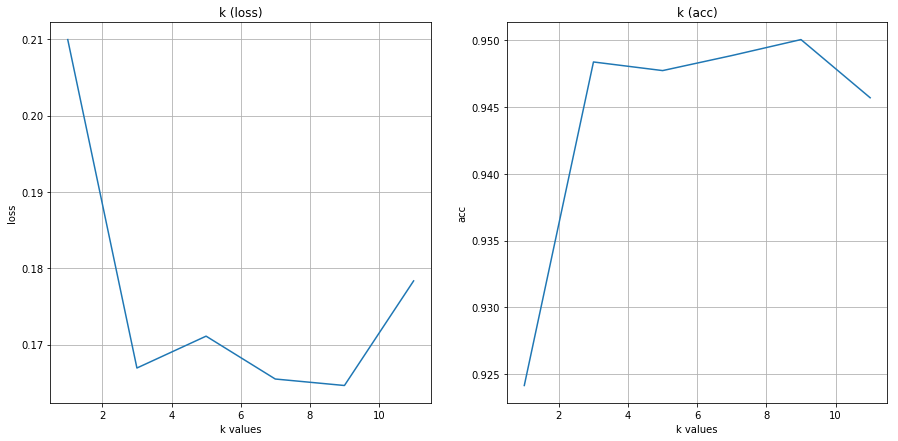

In [110]:
plot_res(param_name, param_res)

Видно, что заметная разница только при увеличении размера окна с 1 до 3. Поскольку некоторые слова не были найдены в embedding'е, то при k=1 иногда возникает ситуация, что по одному нулевому вектору надо предсказать часть речи, что весьма затруднительно. Когда же k >= 3, то менее вероятно что все три слова - нулевые векторы, а имея хоть какой-то контекст, уже можно предсказать часть речи.

При дальнейшем увеличении размера окна, в теории, качество должно немного расти, поскольку мы знаем больше о контексте слова, однако флуктуации при одном запуске процесса обучения заметней чем этот планируемый рост точности.

Брать совсем большие размеры окна не имеет смысла, ибо средняя длина предложения равна:

In [119]:
np.mean([len(sent) fosentensesent in sentenses])

11.882803573283473

Однако, судя по графикам, наилучшая точность достигается при k=9, поэтому в дальнейших экспериментах будем брать такой размер окна.

In [112]:
kwargs['k'] = 9

## Исследуем зависимость от количества нейронов в скрытом слое n_units

  0%|          | 0/6 [00:00<?, ?it/s]

Param_name: n_units, current value: 64
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 29s 93us/step - loss: 0.3821 - acc: 0.8841 - val_loss: 0.2683 - val_acc: 0.9183
Epoch 2/10
308868/308868 [==============================] - 27s 86us/step - loss: 0.1895 - acc: 0.9408 - val_loss: 0.2468 - val_acc: 0.9236
Epoch 3/10
308868/308868 [==============================] - 27s 88us/step - loss: 0.1669 - acc: 0.9471 - val_loss: 0.2384 - val_acc: 0.9264
Epoch 4/10
308868/308868 [==============================] - 27s 87us/step - loss: 0.1559 - acc: 0.9507 - val_loss: 0.2324 - val_acc: 0.9295
Epoch 5/10
308868/308868 [==============================] - 27s 88us/step - loss: 0.1487 - acc: 0.9523 - val_loss: 0.2234 - val_acc: 0.9312
Epoch 6/10
308868/308868 [==============================] - 27s 87us/step - loss: 0.1427 - acc: 0.9542 - val_loss: 0.2319 - val_acc: 0.9300


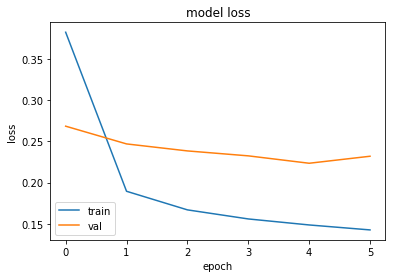

114396/114396 [==============================] - 8s 70us/step


 17%|█▋        | 1/6 [02:53<14:29, 173.84s/it]

Loss: 0.172, acc: 94.68%
Param_name: n_units, current value: 128
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 48s 155us/step - loss: 0.3245 - acc: 0.9010 - val_loss: 0.2587 - val_acc: 0.9221
Epoch 2/10
308868/308868 [==============================] - 45s 146us/step - loss: 0.1642 - acc: 0.9486 - val_loss: 0.2387 - val_acc: 0.9282
Epoch 3/10
308868/308868 [==============================] - 44s 143us/step - loss: 0.1439 - acc: 0.9545 - val_loss: 0.2279 - val_acc: 0.9311
Epoch 4/10
308868/308868 [==============================] - 45s 145us/step - loss: 0.1310 - acc: 0.9587 - val_loss: 0.2249 - val_acc: 0.9337


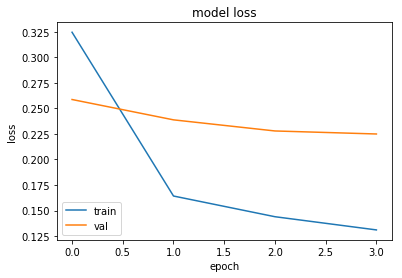

114396/114396 [==============================] - 11s 96us/step


 33%|███▎      | 2/6 [06:09<12:18, 184.68s/it]

Loss: 0.167, acc: 94.97%
Param_name: n_units, current value: 192
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 62s 201us/step - loss: 0.3012 - acc: 0.9085 - val_loss: 0.2505 - val_acc: 0.9230
Epoch 2/10
308868/308868 [==============================] - 62s 199us/step - loss: 0.1590 - acc: 0.9503 - val_loss: 0.2375 - val_acc: 0.9299
Epoch 3/10
308868/308868 [==============================] - 61s 198us/step - loss: 0.1355 - acc: 0.9568 - val_loss: 0.2322 - val_acc: 0.9318
Epoch 4/10
308868/308868 [==============================] - 62s 201us/step - loss: 0.1211 - acc: 0.9610 - val_loss: 0.2268 - val_acc: 0.9350
Epoch 5/10
308868/308868 [==============================] - 61s 199us/step - loss: 0.1102 - acc: 0.9641 - val_loss: 0.2308 - val_acc: 0.9341


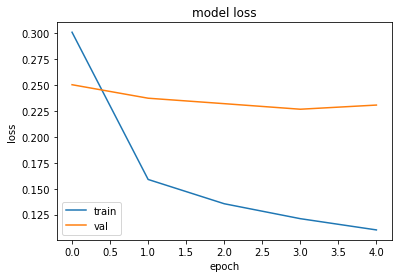

114396/114396 [==============================] - 14s 121us/step


 50%|█████     | 3/6 [11:34<11:34, 231.46s/it]

Loss: 0.169, acc: 94.99%
Param_name: n_units, current value: 256
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 82s 264us/step - loss: 0.2868 - acc: 0.9134 - val_loss: 0.2560 - val_acc: 0.9245
Epoch 2/10
308868/308868 [==============================] - 88s 284us/step - loss: 0.1549 - acc: 0.9520 - val_loss: 0.2478 - val_acc: 0.9300
Epoch 3/10
308868/308868 [==============================] - 83s 269us/step - loss: 0.1322 - acc: 0.9584 - val_loss: 0.2303 - val_acc: 0.9335
Epoch 4/10
308868/308868 [==============================] - 79s 254us/step - loss: 0.1142 - acc: 0.9635 - val_loss: 0.2306 - val_acc: 0.9349


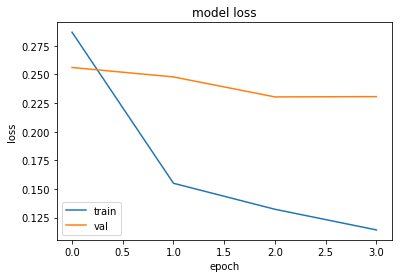

114396/114396 [==============================] - 17s 147us/step


 67%|██████▋   | 4/6 [17:24<08:42, 261.18s/it]

Loss: 0.173, acc: 94.97%
Param_name: n_units, current value: 512
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 159s 516us/step - loss: 0.2781 - acc: 0.9191 - val_loss: 0.2808 - val_acc: 0.9216
Epoch 2/10
308868/308868 [==============================] - 153s 497us/step - loss: 0.1583 - acc: 0.9530 - val_loss: 0.2531 - val_acc: 0.9290
Epoch 3/10
308868/308868 [==============================] - 153s 496us/step - loss: 0.1261 - acc: 0.9611 - val_loss: 0.2563 - val_acc: 0.9322


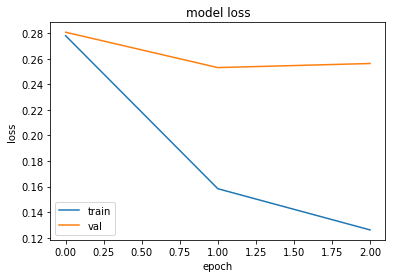

114396/114396 [==============================] - 28s 247us/step


 83%|████████▎ | 5/6 [25:41<05:08, 308.32s/it]

Loss: 0.185, acc: 94.85%
Param_name: n_units, current value: 1024
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 291s 943us/step - loss: 0.3067 - acc: 0.9183 - val_loss: 0.3230 - val_acc: 0.9180
Epoch 2/10
308868/308868 [==============================] - 290s 940us/step - loss: 0.1766 - acc: 0.9516 - val_loss: 0.3267 - val_acc: 0.9193


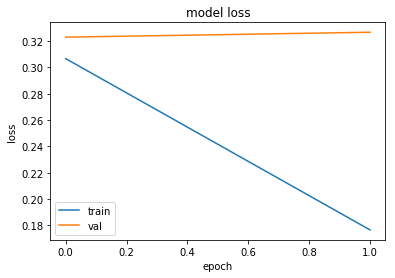

114396/114396 [==============================] - 53s 461us/step


100%|██████████| 6/6 [36:18<00:00, 363.06s/it]

Loss: 0.233, acc: 93.96%
CPU times: user 1h 32min 25s, sys: 5min 6s, total: 1h 37min 31s
Wall time: 36min 22s


In [117]:
%%time
param_name = 'n_units'
param_values = [64, 128, 192, 256, 512, 1024]

param_res = test_param(param_name, param_values, **kwargs)

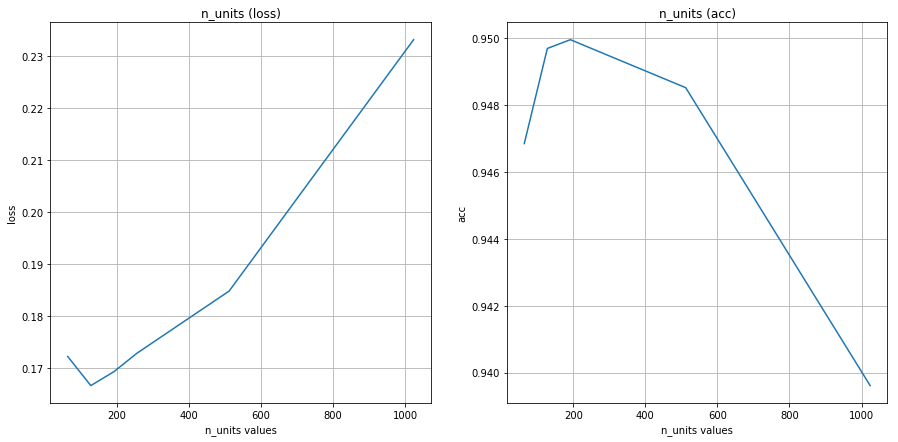

In [118]:
plot_res(param_name, param_res)

In [133]:
kwargs['n_units'] = 192

## Исследуем зависимость от количества нейронов в скрытом слое n_units


  0%|          | 0/7 [00:00<?, ?it/s]

Param_name: dense_activation, current value: elu
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
  8832/308868 [..............................] - ETA: 1:58 - loss: 1.6098 - acc: 0.5262


Exception in thread Thread-10:
Traceback (most recent call last):
  File "/Users/maxim/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/maxim/miniconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/maxim/miniconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



308868/308868 [==============================] - 81s 263us/step - loss: 0.3258 - acc: 0.9009 - val_loss: 0.3095 - val_acc: 0.9118
Epoch 2/10
308868/308868 [==============================] - 81s 262us/step - loss: 0.2079 - acc: 0.9361 - val_loss: 0.2888 - val_acc: 0.9135
Epoch 3/10
308868/308868 [==============================] - 70s 225us/step - loss: 0.1845 - acc: 0.9427 - val_loss: 0.2660 - val_acc: 0.9194
Epoch 4/10
308868/308868 [==============================] - 69s 225us/step - loss: 0.1646 - acc: 0.9483 - val_loss: 0.2512 - val_acc: 0.9257
Epoch 5/10
308868/308868 [==============================] - 71s 230us/step - loss: 0.1499 - acc: 0.9526 - val_loss: 0.2440 - val_acc: 0.9278
Epoch 6/10
308868/308868 [==============================] - 68s 219us/step - loss: 0.1380 - acc: 0.9559 - val_loss: 0.2329 - val_acc: 0.9311
Epoch 7/10
308868/308868 [==============================] - 75s 243us/step - loss: 0.1285 - acc: 0.9585 - val_loss: 0.2292 - val_acc: 0.9307


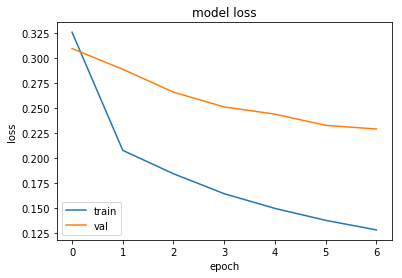

114396/114396 [==============================] - 19s 164us/step


 14%|█▍        | 1/7 [08:56<53:40, 536.73s/it]

Loss: 0.170, acc: 94.80%
Param_name: dense_activation, current value: selu
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 94s 305us/step - loss: 0.3282 - acc: 0.9005 - val_loss: 0.3084 - val_acc: 0.9075
Epoch 2/10
308868/308868 [==============================] - 98s 318us/step - loss: 0.2130 - acc: 0.9345 - val_loss: 0.2864 - val_acc: 0.9149
Epoch 3/10
308868/308868 [==============================] - 120s 387us/step - loss: 0.1926 - acc: 0.9401 - val_loss: 0.2751 - val_acc: 0.9192
Epoch 4/10
308868/308868 [==============================] - 110s 355us/step - loss: 0.1782 - acc: 0.9442 - val_loss: 0.2638 - val_acc: 0.9218
Epoch 5/10
308868/308868 [==============================] - 92s 299us/step - loss: 0.1666 - acc: 0.9474 - val_loss: 0.2546 - val_acc: 0.9251
Epoch 6/10
308868/308868 [==============================] - 87s 282us/step - loss: 0.1569 - acc: 0.9505 - val_loss: 0.2500 - val_acc: 0.9249


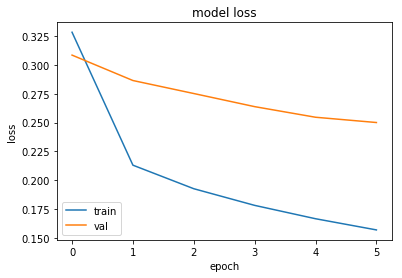

114396/114396 [==============================] - 16s 142us/step


 29%|██▊       | 2/7 [19:17<48:12, 578.58s/it]

Loss: 0.191, acc: 94.10%
Param_name: dense_activation, current value: relu
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 67s 218us/step - loss: 0.3005 - acc: 0.9087 - val_loss: 0.2564 - val_acc: 0.9206
Epoch 2/10
308868/308868 [==============================] - 76s 247us/step - loss: 0.1587 - acc: 0.9507 - val_loss: 0.2461 - val_acc: 0.9267
Epoch 3/10
308868/308868 [==============================] - 79s 256us/step - loss: 0.1360 - acc: 0.9572 - val_loss: 0.2394 - val_acc: 0.9293
Epoch 4/10
308868/308868 [==============================] - 72s 232us/step - loss: 0.1205 - acc: 0.9611 - val_loss: 0.2297 - val_acc: 0.9326
Epoch 5/10
308868/308868 [==============================] - 96s 311us/step - loss: 0.1100 - acc: 0.9645 - val_loss: 0.2294 - val_acc: 0.9354


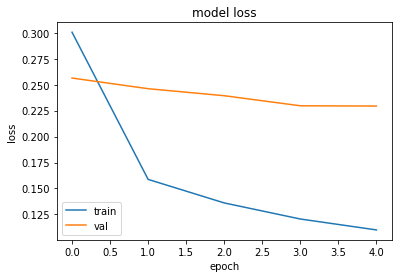

114396/114396 [==============================] - 24s 212us/step


 43%|████▎     | 3/7 [26:15<35:01, 525.31s/it]

Loss: 0.169, acc: 94.99%
Param_name: dense_activation, current value: tanh
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 78s 252us/step - loss: 0.3265 - acc: 0.9006 - val_loss: 0.3051 - val_acc: 0.9084
Epoch 2/10
308868/308868 [==============================] - 67s 218us/step - loss: 0.2091 - acc: 0.9352 - val_loss: 0.2808 - val_acc: 0.9156
Epoch 3/10
308868/308868 [==============================] - 65s 212us/step - loss: 0.1824 - acc: 0.9433 - val_loss: 0.2636 - val_acc: 0.9214
Epoch 4/10
308868/308868 [==============================] - 65s 212us/step - loss: 0.1636 - acc: 0.9487 - val_loss: 0.2440 - val_acc: 0.9274
Epoch 5/10
308868/308868 [==============================] - 68s 219us/step - loss: 0.1472 - acc: 0.9535 - val_loss: 0.2373 - val_acc: 0.9280
Epoch 6/10
308868/308868 [==============================] - 70s 228us/step - loss: 0.1352 - acc: 0.9572 - val_loss: 0.2330 - val_acc: 0.9308


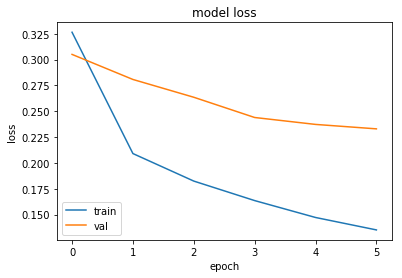

114396/114396 [==============================] - 17s 146us/step


 57%|█████▋    | 4/7 [33:32<25:09, 503.13s/it]

Loss: 0.173, acc: 94.70%
Param_name: dense_activation, current value: sigmoid
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 83s 270us/step - loss: 0.3263 - acc: 0.9008 - val_loss: 0.3118 - val_acc: 0.9066
Epoch 2/10
308868/308868 [==============================] - 82s 264us/step - loss: 0.2181 - acc: 0.9328 - val_loss: 0.2971 - val_acc: 0.9119
Epoch 3/10
308868/308868 [==============================] - 81s 262us/step - loss: 0.2016 - acc: 0.9375 - val_loss: 0.3007 - val_acc: 0.9129 1s - loss: 0.2019 - acc: 0. - ETA: 1s -


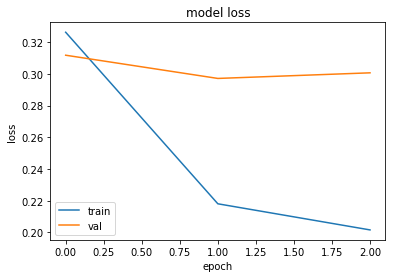

114396/114396 [==============================] - 19s 168us/step


 71%|███████▏  | 5/7 [38:00<15:12, 456.18s/it]

Loss: 0.223, acc: 93.26%
Param_name: dense_activation, current value: hard_sigmoid
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 61s 197us/step - loss: 0.3248 - acc: 0.9012 - val_loss: 0.3271 - val_acc: 0.9063
Epoch 2/10
308868/308868 [==============================] - 62s 199us/step - loss: 0.2198 - acc: 0.9327 - val_loss: 0.3067 - val_acc: 0.9090
Epoch 3/10
308868/308868 [==============================] - 63s 205us/step - loss: 0.2046 - acc: 0.9365 - val_loss: 0.3024 - val_acc: 0.9115


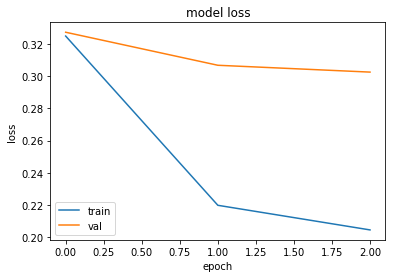

114396/114396 [==============================] - 15s 131us/step


 86%|████████▌ | 6/7 [41:26<06:54, 414.38s/it]

Loss: 0.225, acc: 93.28%
Param_name: dense_activation, current value: softmax
Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 141s 457us/step - loss: 0.3634 - acc: 0.8901 - val_loss: 0.2653 - val_acc: 0.9184
Epoch 2/10
308868/308868 [==============================] - 137s 445us/step - loss: 0.1764 - acc: 0.9447 - val_loss: 0.2334 - val_acc: 0.9278
Epoch 3/10
308868/308868 [==============================] - 138s 445us/step - loss: 0.1508 - acc: 0.9526 - val_loss: 0.2248 - val_acc: 0.9312
Epoch 4/10
308868/308868 [==============================] - 138s 446us/step - loss: 0.1346 - acc: 0.9572 - val_loss: 0.2186 - val_acc: 0.9332
Epoch 5/10
308868/308868 [==============================] - 138s 446us/step - loss: 0.1230 - acc: 0.9606 - val_loss: 0.2210 - val_acc: 0.9331


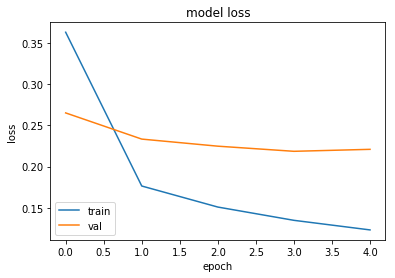

114396/114396 [==============================] - 18s 159us/step


100%|██████████| 7/7 [53:19<00:00, 457.05s/it]

Loss: 0.163, acc: 95.01%
CPU times: user 2h 4min 30s, sys: 5min 50s, total: 2h 10min 21s
Wall time: 53min 22s


In [140]:
%%time
param_name = 'dense_activation'
param_values = ['elu', 'selu','relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'softmax']

param_res = test_param(param_name, param_values, **kwargs)

In [141]:
def plot_res_categorical_data(param_name, param_res):
    x, loss, acc = list(map(list, zip(*[(param, v[0], v[1]) for param, v in param_res.items()])))
    plt.figure(figsize=(15, 7))
    
    plt.subplot(1, 2, 1)
    plt.scatter(x, loss)
    plt.xlabel(param_name + " values")
    plt.ylabel('loss')
    plt.grid(True)
    plt.title(param_name + ' (loss)')
    
    plt.subplot(1, 2, 2)
    plt.scatter(x, acc)
    plt.xlabel(param_name + " values")
    plt.ylabel('acc')
    plt.grid(True)
    plt.title(param_name + ' (acc)')

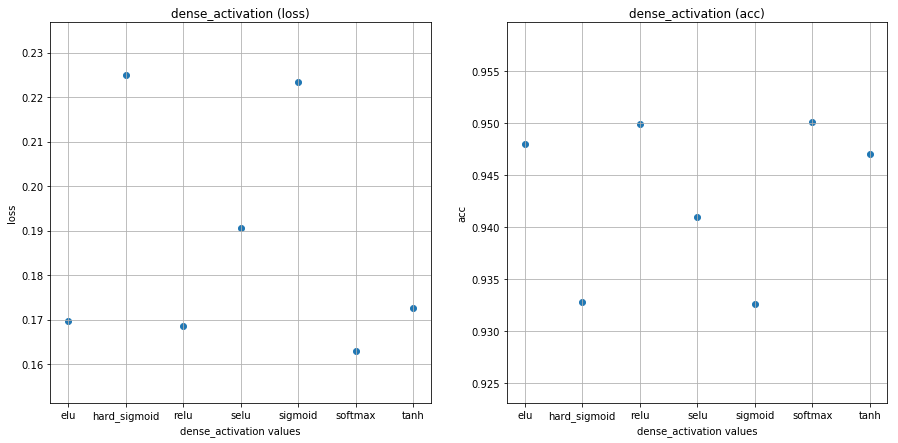

In [142]:
plot_res_categorical_data(param_name, param_res)

### Часть 5 [2 балла] Анализ ошибок
1. Привидите примеры из тестового множества, на которых нейронная сеть ошибается. Объясните, почему возникают ошибки.
2. Протестируйте нейронную сеть на произвольном предложении (не из тестовых данных). Возникают ли ошибки? Почему?

Выберем и обучим лучшую модель

In [144]:
kwargs

{'batch_size': 128,
 'callbacks': [<keras.callbacks.EarlyStopping at 0x12a52a828>],
 'dense_activation': 'relu',
 'embedding_matrix': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.12242   ,  0.0037909 ,  0.010159  , ..., -0.017005  ,
          0.030068  ,  0.21763   ],
        [-0.28093001,  0.19175   , -0.15895   , ..., -0.030691  ,
          0.12292   , -0.0039144 ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 'embedding_size': 300,
 'k': 9,
 'lr': 0.001,
 'n_epoches': 10,
 'n_initial_epoch': 0,
 'n_units': 192,
 'output_size': 14,
 'vocab_size': 79792}

In [145]:
model = build_model(**kwargs)

In [146]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 9, 300)            23937600  
_________________________________________________________________
dense_65 (Dense)             (None, 9, 192)            57792     
_________________________________________________________________
batch_normalization_29 (Batc (None, 9, 192)            768       
_________________________________________________________________
flatten_32 (Flatten)         (None, 1728)              0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 1728)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 14)                24206     
Total params: 24,020,366
Trainable params: 82,382
Non-trainable params: 23,937,984
___________________________________________________________

In [148]:
%%time
X = np.asarray([get_window(i, sent, kwargs['k']) 
                            for sent in encoded_sentences for i, word in enumerate(sent)], dtype=np.int32)
X_train, X_test = X[:int(X.shape[0] * 0.75)], X[int(X.shape[0] * 0.75):]

history = train_model(model, X_train, y_train, **kwargs)

Train on 308868 samples, validate on 34319 samples
Epoch 1/10
308868/308868 [==============================] - 63s 204us/step - loss: 0.3011 - acc: 0.9088 - val_loss: 0.2579 - val_acc: 0.9240
Epoch 2/10
308868/308868 [==============================] - 58s 189us/step - loss: 0.1585 - acc: 0.9506 - val_loss: 0.2458 - val_acc: 0.9260
Epoch 3/10
308868/308868 [==============================] - 56s 181us/step - loss: 0.1353 - acc: 0.9574 - val_loss: 0.2352 - val_acc: 0.9308
Epoch 4/10
308868/308868 [==============================] - 58s 186us/step - loss: 0.1212 - acc: 0.9611 - val_loss: 0.2272 - val_acc: 0.9344
Epoch 5/10
308868/308868 [==============================] - 57s 186us/step - loss: 0.1103 - acc: 0.9642 - val_loss: 0.2268 - val_acc: 0.9348
CPU times: user 13min 47s, sys: 34 s, total: 14min 21s
Wall time: 4min 54s


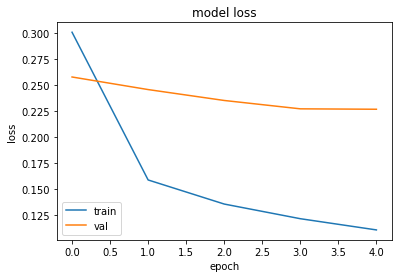

In [149]:
history_plot(history)

In [150]:
path_to_folder = 'data/models/'
save_model(model, path_to_folder)

Created:
data/models/model_weights_2.h5
data/models/model_architecture_2.json


In [151]:
eval_test_score(model, X_test, y_test)

114396/114396 [==============================] - 14s 124us/step
Loss: 0.168, acc: 95.12%


(0.16750970244376523, 0.951169621321683)

Посмотрим на ошибки классификации

In [155]:
y_pred = model.predict_classes(X_test)

114396/114396 [==============================] - 13s 117us/step


In [156]:
y_pred

array([ 6, 11,  1, ..., 13, 11, 11])

Индексы косячных слов

In [160]:
wrong_idx = np.where(y_pred != y_test)[0] + y_train.shape[0]

In [164]:
print(len(wrong_idx), wrong_idx)

5586 [343211 343221 343222 ... 457572 457575 457581]


Печатает слово, в котором ошиблись, предложение и метки

In [181]:
def print_word_with_context(index, sentenses, y_pred, y_test, label_encoder):
    i = index
    j = 0
    while i >= 0: 
        i -= len(sentenses[j])
        j += 1
    j -= 1
    sent = sentenses[j]
    i += len(sent)
    word = sent[i]
    print("Word: ", word)
    print("Sent: ", sent)
    print("True tag: ", label_encoder.classes_[y_test[index-y_train.shape[0]]], 
          " pred tag: ", label_encoder.classes_[y_pred[index-y_train.shape[0]]])

In [182]:
label_encoder.classes_

array(['ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART',
       'PRON', 'PROPN', 'PUNCT', 'VERB', 'X'], dtype='<U5')

Посмотрим на примеры

In [183]:
print_word_with_context(wrong_idx[0], sentenses, y_pred, y_test, label_encoder)

Word:  какой-то
Sent:  ['Напоследок', 'парень', 'опять', 'задумчиво', 'сказал', '"', 'да', ',', 'я', 'уже', 'собирался', 'останавливаться', ',', 'запах', 'был', 'какой-то', 'странный', '"', '.']
True tag:  DET  pred tag:  X


In [184]:
print_word_with_context(wrong_idx[1], sentenses, y_pred, y_test, label_encoder)

Word:  травлю
Sent:  ['Теперь', 'травлю', 'раскрутчика', ',', 'который', 'весь', 'ЖЖ', 'засрал', '.']
True tag:  VERB  pred tag:  NOUN


In [185]:
print_word_with_context(wrong_idx[2], sentenses, y_pred, y_test, label_encoder)

Word:  раскрутчика
Sent:  ['Теперь', 'травлю', 'раскрутчика', ',', 'который', 'весь', 'ЖЖ', 'засрал', '.']
True tag:  X  pred tag:  NOUN


In [186]:
print_word_with_context(wrong_idx[3], sentenses, y_pred, y_test, label_encoder)

Word:  1999
Sent:  ['Прошу', 'любить', 'и', 'жаловать', ':', 'Three', 'Dog', 'Vineyards', '1999', '.']
True tag:  NUM  pred tag:  X


In [187]:
print_word_with_context(wrong_idx[4], sentenses, y_pred, y_test, label_encoder)

Word:  теде
Sent:  ['Со', 'всеми', 'положенными', 'взрывами', ',', 'хвостами', ',', 'ощущениями', 'и', 'теде', 'и', 'тепе', '.']
True tag:  PROPN  pred tag:  X


In [188]:
print_word_with_context(wrong_idx[5], sentenses, y_pred, y_test, label_encoder)

Word:  права
Sent:  ['autumnburn', 'права', '.']
True tag:  ADJ  pred tag:  NOUN


In [189]:
print_word_with_context(wrong_idx[6], sentenses, y_pred, y_test, label_encoder)

Word:  насчет
Sent:  ['не', 'знаю', ',', 'как', 'насчет', '"', 'взять', 'лошадку', 'в', 'прокат', '"', '%)', ',', 'но', 'за', 'тренировкой', 'группы', 'из', 'пяти', 'ковбойш', 'я', 'понаблюдал', '.']
True tag:  ADP  pred tag:  VERB


In [190]:
print_word_with_context(wrong_idx[7], sentenses, y_pred, y_test, label_encoder)

Word:  %)
Sent:  ['не', 'знаю', ',', 'как', 'насчет', '"', 'взять', 'лошадку', 'в', 'прокат', '"', '%)', ',', 'но', 'за', 'тренировкой', 'группы', 'из', 'пяти', 'ковбойш', 'я', 'понаблюдал', '.']
True tag:  PUNCT  pred tag:  X


In [191]:
print_word_with_context(wrong_idx[8], sentenses, y_pred, y_test, label_encoder)

Word:  ковбойш
Sent:  ['не', 'знаю', ',', 'как', 'насчет', '"', 'взять', 'лошадку', 'в', 'прокат', '"', '%)', ',', 'но', 'за', 'тренировкой', 'группы', 'из', 'пяти', 'ковбойш', 'я', 'понаблюдал', '.']
True tag:  X  pred tag:  PUNCT


In [192]:
print_word_with_context(wrong_idx[9], sentenses, y_pred, y_test, label_encoder)

Word:  как
Sent:  ['как', 'не', 'надо']
True tag:  ADV  pred tag:  CONJ


В основном возникают "обычные" ошибки(связанные с предсказанием X). Но некоторые ошибки(например, idx 1 и 5) возникают из-за двойного смысла слов, значение которых зависит от контекста, но нейронка не уловила этот контекст.

Составим свои предложения и посмотрим как сеть с ними справится

In [222]:
my_sentences = [
    'мама мыла оконное стекло , потому что оно грязное',
    'несколько дождевых капель стекло по ее зонту',
    'ключи от замка у него дома',
    'штурмом взять замок не получалось, поэтому главнокомандующий решил дождаться подкрепления'
]
my_sentences_encoded = t.texts_to_sequences(my_sentences)

In [223]:
my_sentences_encoded

[[2510, 1214, 2, 207, 15, 239],
 [117, 71953, 24824, 1214, 13, 3703],
 [18774, 22, 19048, 35, 260],
 [1419, 2977, 9, 140, 1310, 29850]]

In [224]:
X_my = np.asarray([get_window(i, sent, kwargs['k']) 
                            for sent in my_sentences_encoded for i, word in enumerate(sent)], dtype=np.int32)

In [225]:
X_my

array([[    0,     0,     0,     0,  2510,  1214,     2,   207,    15],
       [    0,     0,     0,  2510,  1214,     2,   207,    15,   239],
       [    0,     0,  2510,  1214,     2,   207,    15,   239,     0],
       [    0,  2510,  1214,     2,   207,    15,   239,     0,     0],
       [ 2510,  1214,     2,   207,    15,   239,     0,     0,     0],
       [ 1214,     2,   207,    15,   239,     0,     0,     0,     0],
       [    0,     0,     0,     0,   117, 71953, 24824,  1214,    13],
       [    0,     0,     0,   117, 71953, 24824,  1214,    13,  3703],
       [    0,     0,   117, 71953, 24824,  1214,    13,  3703,     0],
       [    0,   117, 71953, 24824,  1214,    13,  3703,     0,     0],
       [  117, 71953, 24824,  1214,    13,  3703,     0,     0,     0],
       [71953, 24824,  1214,    13,  3703,     0,     0,     0,     0],
       [    0,     0,     0,     0, 18774,    22, 19048,    35,   260],
       [    0,     0,     0, 18774,    22, 19048,    35,   260, 

In [226]:
y_my = model.predict_classes(X_my)

23/23 [==============================] - 0s 254us/step


In [227]:
idx2word = {idx: word for word, idx in t.word_index.items()}

In [228]:
print(*zip(label_encoder.classes_[y_my], 
           [idx2word[word_idx] for sent in my_sentences_encoded for word_idx in sent]), sep='\n')

('NOUN', 'мама')
('NOUN', 'стекло')
('PUNCT', ',')
('ADV', 'потому')
('PRON', 'что')
('PRON', 'оно')
('NUM', 'несколько')
('ADJ', 'дождевых')
('NOUN', 'капель')
('NOUN', 'стекло')
('ADP', 'по')
('PRON', 'ее')
('NOUN', 'ключи')
('ADP', 'от')
('NOUN', 'замка')
('ADP', 'у')
('NOUN', 'дома')
('VERB', 'взять')
('NOUN', 'замок')
('PART', 'не')
('ADV', 'поэтому')
('VERB', 'решил')
('VERB', 'дождаться')


С "замком" получилось глупо, ибо оба смысла - существительные, а на "стекло" нейронка попалась: во втором предложении это глагол.